In [1]:
import pandas as pd
import re
from dateutil import parser
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, f_oneway

In [2]:
# import all the csv files

# customers
customers = pd.read_csv('sales_data/customers.csv')

# products
products = pd.read_csv('sales_data/products.csv')

# return discounts
returns_discounts = pd.read_csv('sales_data/returns_discounts.csv')

# sales transactions
sales_transactions = pd.read_csv('sales_data/sales_transactions.csv')

# EXPLORE THE CUSTOMER *TABLE*

In [3]:
customers.info()

# 1 value null

# mismatched format in the date columns
def clean_date_string(date_str):
  if pd.isna(date_str):
    return pd.NaT

  # put the date in string and remove whitespace
  date_str = str(date_str).strip().lower()

  # [] -> OR ^ -> not \w -> letter and digits, \s -> whitespace /-, replace all those symbols by ''
  date_str = re.sub(r'[^\w\s/-]', '', date_str)

  # replace / or . by -
  date_str = re.sub(r'[/.]', '-', date_str)

  try:
    date_str = parser.parse(date_str).strftime('%Y-%m-%d')
    return date_str
  except:
    return pd.NaT

customers['signup_date_cleaned'] = customers['signup_date'].apply(clean_date_string)

# mismatched format in the email column
def clean_email_string(email_str):
  email_str  = str(email_str)
  if '@' in email_str:
      username, domain = email_str.split('@')
      if not domain.endswith('.com'):
         email_str = username + '@' + domain + '.com'
  return email_str

customers['email_cleaned'] = customers['email'].apply(clean_email_string)

# let's clean also the region
def clean_name(name):
  name = str(name).strip().lower()
  if name in ['nan', 'n/a', 'null']:
    return pd.NA
  return name.capitalize()

customers['region_cleaned'] = customers['region'].apply(clean_name)

customers = customers.drop(columns=['region', 'email', 'signup_date'])
customers = customers.rename(columns={'region_cleaned' : 'region',
                                      'email_cleaned' : 'email',
                                      'signup_date_cleaned' : 'signup_date'})

customers['signup_date'] = pd.to_datetime(customers['signup_date'])

# exclude null regions
customers = customers[~customers['region'].isna()]

for col in customers.columns:
  print(customers[col].value_counts(dropna=False))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   customer_id  200 non-null    object
 1   name         200 non-null    object
 2   email        200 non-null    object
 3   region       200 non-null    object
 4   signup_date  200 non-null    object
dtypes: object(5)
memory usage: 7.9+ KB
customer_id
CUST1000    1
CUST1001    1
CUST1002    1
CUST1003    1
CUST1004    1
           ..
CUST1195    1
CUST1196    1
CUST1197    1
CUST1198    1
CUST1199    1
Name: count, Length: 200, dtype: int64
name
Allison Hill       1
Noah Rhodes        1
Angie Henderson    1
Daniel Wagner      1
Cristian Santos    1
                  ..
Allen Rosales      1
Daniel Salinas     1
Spencer Haynes     1
Adam Vaughan       1
Nathan Freeman     1
Name: count, Length: 200, dtype: int64
signup_date
2024-07-11    3
2023-10-26    2
2025-04-19    2
2024-03-16    2
2024-04-10   

# EXPLORE THE PRODUCT TABLE

In [4]:
products.info()

# there are misformat in th the product name
def clean_product_name(product):
  product = clean_name(product)
  if product.lower() == 'widgget':
    product = 'widget'.capitalize()
  return product

# drop the price


products['product_name_cleaned'] = products['product_name'].apply(clean_product_name)

# delete the old columns
products.drop(columns=['product_name'], inplace=True)
products.rename(columns={'product_name_cleaned':'product_name'}, inplace=True)

# filter on the products where the price is negative
#products['price'] = products['price'].astype(int)
products = products[(products['price'] >= 0) | (~products['category'].isna())]

for col in products.columns:
  print(products[col].value_counts(dropna=False))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_id    50 non-null     object 
 1   product_name  50 non-null     object 
 2   category      50 non-null     object 
 3   price         50 non-null     float64
dtypes: float64(1), object(3)
memory usage: 1.7+ KB
product_id
PROD100    1
PROD101    1
PROD102    1
PROD103    1
PROD104    1
PROD105    1
PROD106    1
PROD107    1
PROD108    1
PROD109    1
PROD110    1
PROD111    1
PROD112    1
PROD113    1
PROD114    1
PROD115    1
PROD116    1
PROD117    1
PROD118    1
PROD119    1
PROD120    1
PROD121    1
PROD122    1
PROD123    1
PROD124    1
PROD125    1
PROD126    1
PROD127    1
PROD128    1
PROD129    1
PROD130    1
PROD131    1
PROD132    1
PROD133    1
PROD134    1
PROD135    1
PROD136    1
PROD137    1
PROD138    1
PROD139    1
PROD140    1
PROD141    1
PROD142    1
PROD143    1
PROD1

# Explore the return discounts

In [5]:
returns_discounts.info()

returns_discounts['return_flag_clean'] = returns_discounts['return_flag'].apply(clean_name)

# drop and rename the cleaned field
returns_discounts = returns_discounts.drop(columns=['return_flag']).rename(columns={'return_flag_clean':'return_flag'})

# 503 and 506 seems to be duplicates, let's have a look
returns_discounts_duplicates = returns_discounts[returns_discounts.duplicated()]

# drop the duplicated values
returns_discounts.drop_duplicates(inplace=True)

for col in returns_discounts.columns:
  print(returns_discounts[col].value_counts(dropna=False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   transaction_id    150 non-null    object 
 1   return_flag       150 non-null    bool   
 2   discount_applied  150 non-null    float64
dtypes: bool(1), float64(1), object(1)
memory usage: 2.6+ KB
transaction_id
TX922056    1
TX312615    1
TX342928    1
TX541301    1
TX997103    1
           ..
TX728177    1
TX487588    1
TX291022    1
TX775118    1
TX489140    1
Name: count, Length: 150, dtype: int64
discount_applied
0.38    7
0.46    6
0.03    6
0.08    5
0.19    5
0.06    5
0.20    5
0.31    5
0.07    5
0.11    5
0.39    5
0.16    4
0.24    4
0.33    4
0.48    4
0.49    4
0.40    4
0.26    4
0.29    4
0.13    3
0.02    3
0.14    3
0.12    3
0.23    3
0.30    3
0.36    3
0.22    3
0.01    2
0.00    2
0.27    2
0.09    2
0.15    2
0.05    2
0.35    2
0.37    2
0.04    2
0.10    2
0.28 

# Explore the sales transactions

In [6]:
sales_transactions.info()

# remove the O for product_id

# format correctly the date

def value_as_int(product):
  if pd.isna(product):
    return pd.NA
  product = int(product)
  return product

# product_id as int

# exclude quantity < 0
sales_transactions['quantity'] = sales_transactions['quantity'].apply(value_as_int)

sales_transactions['transaction_id'] = sales_transactions['transaction_id'].astype=(int)

# drop invalid  and the point
sales_transactions['price_each'] = pd.to_numeric(sales_transactions['price_each'], errors='coerce')

# apply the clean date
sales_transactions['date'] = sales_transactions['date'].apply(clean_date_string)
sales_transactions['date'] = pd.to_datetime(sales_transactions['date'])

for col in sales_transactions.columns:
  print(sales_transactions[col].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   transaction_id  1000 non-null   object 
 1   customer_id     1000 non-null   object 
 2   product_id      1000 non-null   object 
 3   quantity        1000 non-null   int64  
 4   price_each      1000 non-null   float64
 5   date            1000 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 47.0+ KB
transaction_id
<class 'int'>    1000
Name: count, dtype: int64
customer_id
CUST1032    11
CUST1006    11
CUST1044    11
CUST1110    10
CUST1063    10
            ..
CUST1067     1
CUST1171     1
CUST1173     1
CUST1078     1
CUST1154     1
Name: count, Length: 198, dtype: int64
product_id
PROD140    31
PROD119    29
PROD128    28
PROD125    26
PROD112    26
PROD137    25
PROD109    25
PROD104    25
PROD134    24
PROD135    24
PROD149    24
PROD118    24
PROD122    24


# Understand Sales Trends

## Monthly and regional sales performance

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   customer_id  200 non-null    object        
 1   name         200 non-null    object        
 2   signup_date  200 non-null    datetime64[ns]
 3   email        200 non-null    object        
 4   region       200 non-null    object        
dtypes: datetime64[ns](1), object(4)
memory usage: 7.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1000 non-null   object        
 1   customer_id     1000 non-null   object        
 2   product_id      1000 non-null   object        
 3   quantity        1000 non-null   int64         
 4   price_each      1000 non-null   float64       
 5   date            1000

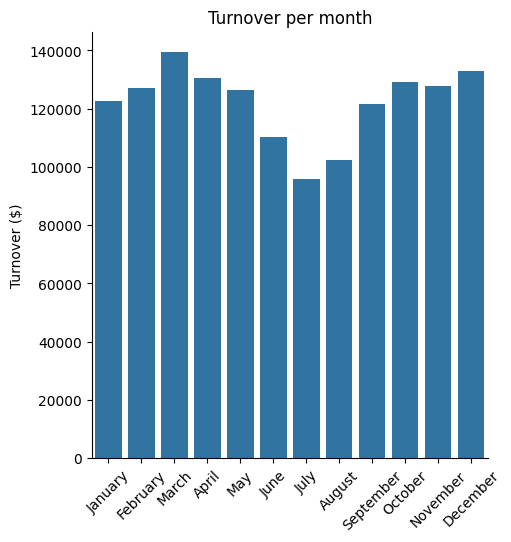

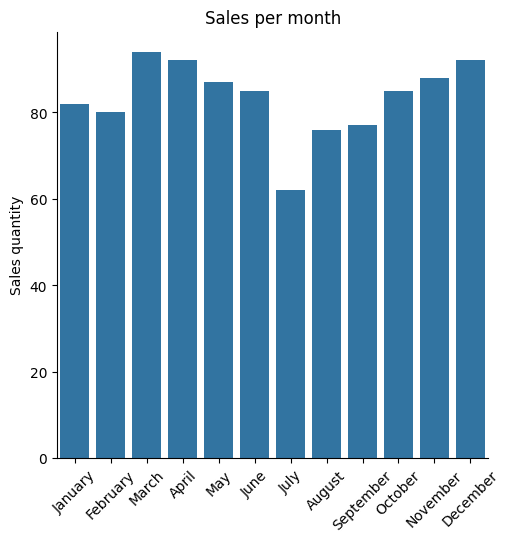

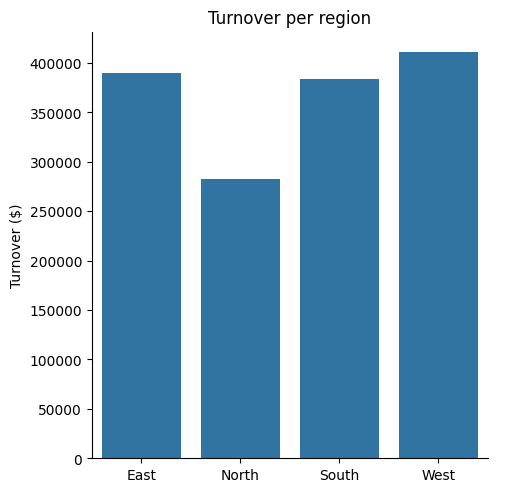

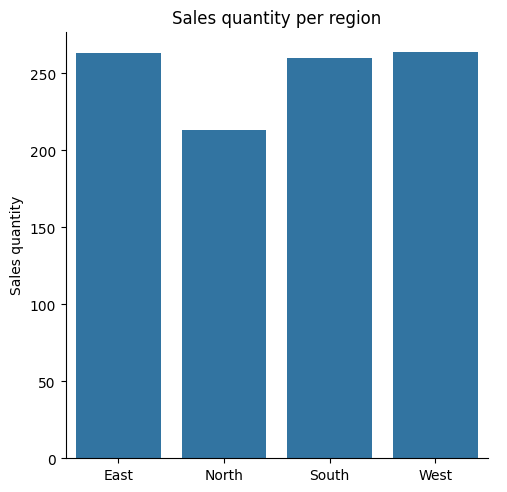

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        1000 non-null   object        
 1   name               1000 non-null   object        
 2   signup_date        1000 non-null   datetime64[ns]
 3   email              1000 non-null   object        
 4   region             1000 non-null   object        
 5   transaction_id     1000 non-null   object        
 6   product_id         1000 non-null   object        
 7   quantity           1000 non-null   int64         
 8   price_each         1000 non-null   float64       
 9   date               1000 non-null   datetime64[ns]
 10  transaction_month  1000 non-null   int32         
 11  signup_month       1000 non-null   int32         
dtypes: datetime64[ns](2), float64(1), int32(2), int64(1), object(6)
memory usage: 86.1+ KB


In [7]:
# customers and sales_transaction
customers.info()
sales_transactions.info()

# we merge the dataframe
customers_sales = customers.merge(sales_transactions, on='customer_id', suffixes=('', '_sales'))

# we create a new column named month
customers_sales['transaction_month'] = pd.to_datetime(customers_sales['date']).dt.month
customers_sales['signup_month'] = pd.to_datetime(customers_sales['signup_date']).dt.month



# monthly sales
monthly_sales = customers_sales.groupby('transaction_month', as_index=False)[
    ['transaction_id', 'quantity', 'price_each']
    ].apply(lambda x:pd.Series({
    'sales_quantity': x['transaction_id'].count(),
    'turnover': (x['quantity'] * x['price_each']).sum()
})).sort_values(by='transaction_month', ascending=True)

# convert the float as int
monthly_sales['sales_quantity'] = monthly_sales['sales_quantity'].apply(value_as_int)

monthly_sales['transaction_month_name'] = pd.to_datetime(
    monthly_sales['transaction_month'], format='%m'
).dt.month_name()

# monthly turnover
sns.catplot(data=monthly_sales, kind='bar', x='transaction_month_name', y='turnover')
plt.title('Turnover per month')
plt.xlabel('')
plt.ylabel('Turnover ($)')
plt.xticks(rotation=45)
plt.show()

# monthly sales quantity
sns.catplot(data=monthly_sales, kind='bar', x='transaction_month_name', y='sales_quantity')
plt.title('Sales per month')
plt.xlabel('')
plt.ylabel('Sales quantity')
plt.xticks(rotation=45)
plt.show()

# regional sales
regional_sales = customers_sales.groupby('region', as_index=False)[
    ['transaction_id', 'quantity', 'price_each']
    ].apply(lambda x:pd.Series({
    'sales_quantity': x['transaction_id'].count(),
    'turnover': (x['quantity'] * x['price_each']).sum()
}))

# convert the float as int
regional_sales['sales_quantity'] = regional_sales['sales_quantity'].apply(value_as_int)

# regional turnover
sns.catplot(data=regional_sales, kind='bar', x='region', y='turnover')
plt.title('Turnover per region')
plt.xlabel('')
plt.ylabel('Turnover ($)')
plt.show()

# regional sales quantity
sns.catplot(data=regional_sales, kind='bar', x='region', y='sales_quantity')
plt.title('Sales quantity per region')
plt.xlabel('')
plt.ylabel('Sales quantity')
plt.show()

customers_sales.info()

Underperforming vs best-seller products

# Customer analysis

Number of new and returning customers over time

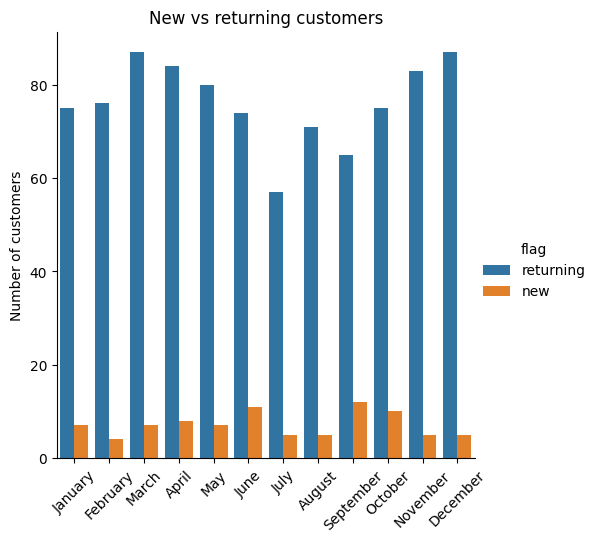

In [8]:
# Number of new vs returning customers

# new customers = sign-up month is the same than transaction month
customers_sales['flag'] = customers_sales.apply(
    lambda row: 'new' if row['signup_month'] == row['transaction_month'] else 'returning',
    axis=1
)

customers_sales['transaction_month'] = pd.to_datetime(customers_sales['date']).dt.month


return_customers_new_monthly = customers_sales.groupby('transaction_month', as_index=False)['flag'].value_counts()\
.sort_values(by='transaction_month', ascending=True)

return_customers_new_monthly['transaction_month_name'] = pd.to_datetime(
    return_customers_new_monthly['transaction_month'], format='%m'
).dt.month_name()

sns.catplot(data=return_customers_new_monthly,
            x='transaction_month_name',
            y='count',
            kind='bar',
            hue='flag')
plt.title('New vs returning customers')
plt.xlabel('')
plt.ylabel('Number of customers')
plt.xticks(rotation=45)
plt.show()

# returning customers = signed up and at least one transaction


# Underperforming vs performing products

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   product_id      1000 non-null   object        
 1   category        1000 non-null   object        
 2   price           1000 non-null   float64       
 3   product_name    1000 non-null   object        
 4   transaction_id  1000 non-null   object        
 5   customer_id     1000 non-null   object        
 6   quantity        1000 non-null   int64         
 7   price_each      1000 non-null   float64       
 8   date            1000 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 70.4+ KB


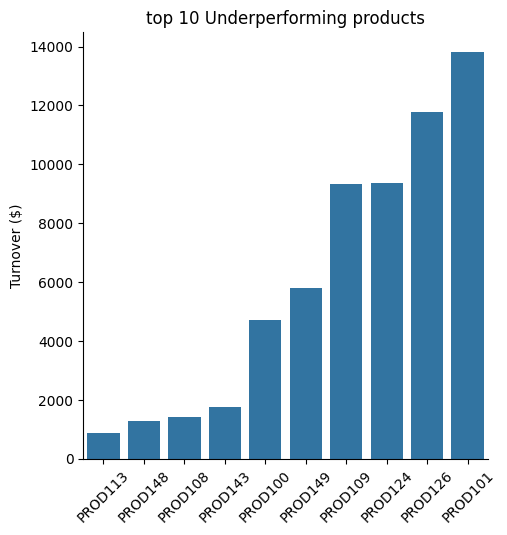

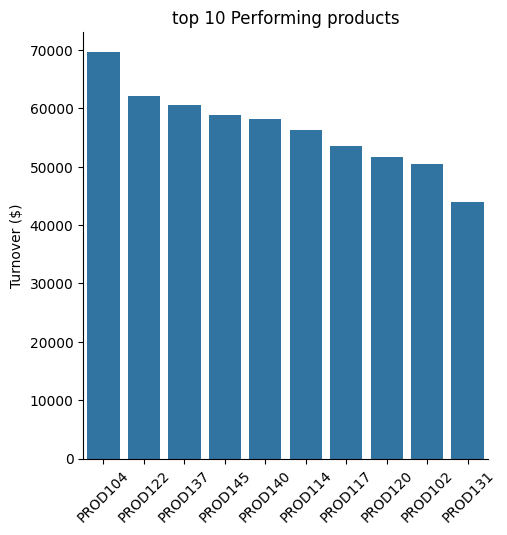

In [9]:
# underperforming products
# products and sales transactions

products_sales = products.merge(sales_transactions, on='product_id')

products_sales.info()

products_sales['turnover'] = products_sales['quantity'] * products_sales['price_each']

products_sales_grouped = products_sales.groupby('product_id', as_index=False)['turnover'].sum()
performing_10_products = products_sales_grouped.sort_values(by='turnover', ascending=False).head(10)
underperforming_10_products = products_sales_grouped.sort_values(by='turnover', ascending=True).head(10)

# performing and undeperforming

sns.catplot(data=underperforming_10_products,
            x='product_id',
            y='turnover',
            kind='bar')
plt.title('top 10 Underperforming products')
plt.xlabel('')
plt.ylabel('Turnover ($)')
plt.xticks(rotation=45)
plt.show()

sns.catplot(data=performing_10_products,
            x='product_id',
            y='turnover',
            kind='bar')
plt.title('top 10 Performing products')
plt.xlabel('')
plt.ylabel('Turnover ($)')
plt.xticks(rotation=45)
plt.show()

# Impacts of discounts on revenue

In [19]:
# discounts and sales-transactions

sales_transactions_discounts = sales_transactions.merge(returns_discounts, on='transaction_id', how='left')

sales_transactions_discounts.info()

total_discount = sales_transactions_discounts['discount_applied'].sum()
total_sales = (sales_transactions_discounts['quantity'] * sales_transactions_discounts['price_each']).sum()

impact_discount_sales = round((total_discount / total_sales)*100, 2)

print(f'impacts of discounts on revenue: {impact_discount_sales}%')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   transaction_id    1000 non-null   object        
 1   customer_id       1000 non-null   object        
 2   product_id        1000 non-null   object        
 3   quantity          1000 non-null   int64         
 4   price_each        1000 non-null   float64       
 5   date              1000 non-null   datetime64[ns]
 6   discount_applied  0 non-null      float64       
 7   return_flag       0 non-null      object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 62.6+ KB
impacts of discounts on revenue: 0.0%


# Detect products with high return rates

In [26]:
# returns_discounts and product

returns_discounts_products = returns_discounts.merge(sales_transactions, on='transaction_id')\
.merge(products, on='product_id')

# add a new column return_rates
returns_discounts_products['return_rate'] = returns_discounts_products['return_flag'].count() / len(returns_discounts_products['return_flag'])

return_rate_products = returns_discounts_products.groupby('product_id', as_index=False)['return_rate'].mean().sort_values(by='return_rate', ascending=False)

print(return_rate_products)

returns_discounts_products.info()

Empty DataFrame
Columns: [product_id, return_rate]
Index: []
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   transaction_id    0 non-null      object        
 1   discount_applied  0 non-null      float64       
 2   return_flag       0 non-null      object        
 3   customer_id       0 non-null      object        
 4   product_id        0 non-null      object        
 5   quantity          0 non-null      int64         
 6   price_each        0 non-null      float64       
 7   date              0 non-null      datetime64[ns]
 8   category          0 non-null      object        
 9   price             0 non-null      float64       
 10  product_name      0 non-null      object        
 11  return_rate       0 non-null      float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(6)
memory usage: 132.0+ bytes


/tmp/ipython-input-3151491490.py:7: RuntimeWarning: invalid value encountered in scalar divide
  returns_discounts_products['return_rate'] = returns_discounts_products['return_flag'].count() / len(returns_discounts_products['return_flag'])


# track discount patterns

nan
nan


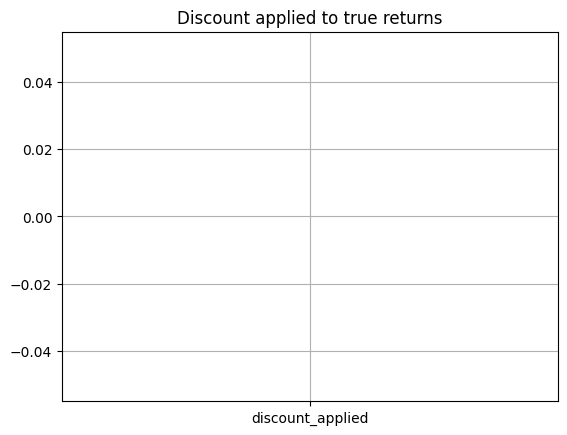

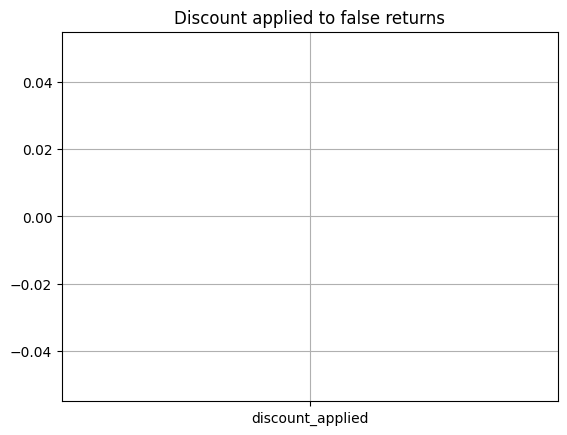

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


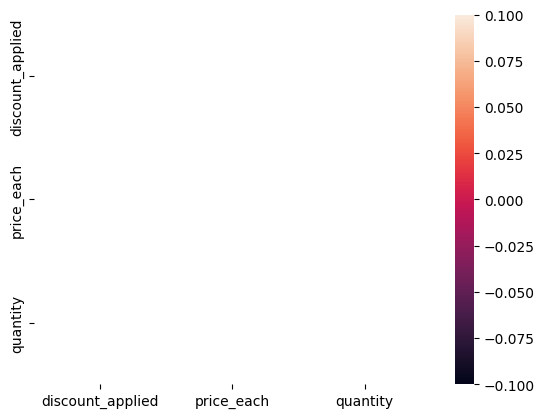

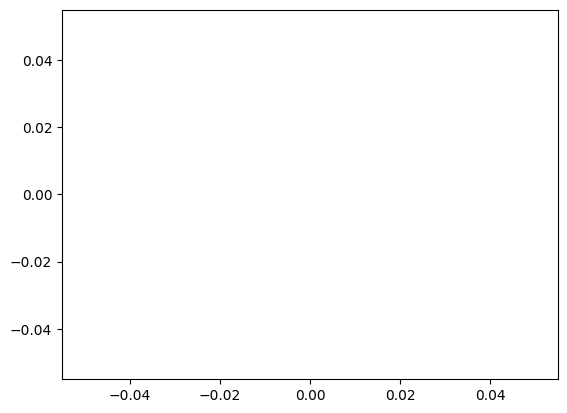

,transaction_id,discount_applied,return_flag,customer_id,product_id,quantity,price_each,date


In [12]:
returns_discounts_sales = returns_discounts.merge(sales_transactions, on='transaction_id')

return_false = returns_discounts_sales[
    returns_discounts_sales['return_flag'] == 'False'
]

return_true = returns_discounts_sales[
    returns_discounts_sales['return_flag'] == 'True'
]

# see if there is a difference in terms of
print(return_false['discount_applied'].mean())
print(return_true['discount_applied'].mean())

return_true.boxplot(column='discount_applied')
plt.title('Discount applied to true returns')
plt.show()

return_false.boxplot(column='discount_applied')
plt.title('Discount applied to false returns')
plt.show()

sns.heatmap(returns_discounts_sales.loc[:, [
    'discount_applied',
    'price_each',
    'quantity']].corr(), annot=True)
plt.show()

sns.scatterplot(data=returns_discounts_sales,
                x='discount_applied',
                y='price_each')
plt.show()

# No strong correlation between the discount applied and other numeric data

# the avg discount applied to the products returned seem to be higer

returns_discounts_sales.head()

# Customers growth monthly

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   customer_id  200 non-null    object        
 1   name         200 non-null    object        
 2   signup_date  200 non-null    datetime64[ns]
 3   email        200 non-null    object        
 4   region       200 non-null    object        
dtypes: datetime64[ns](1), object(4)
memory usage: 7.9+ KB


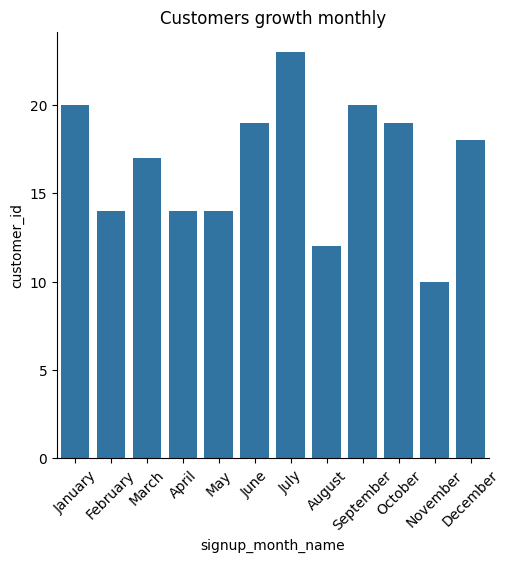

In [13]:
customers.info()

customers['signup_month'] = pd.to_datetime(customers['signup_date']).dt.month


monthly_customers = customers.groupby('signup_month', as_index=False)['customer_id']\
.count().sort_values(by='signup_month', ascending=True)

monthly_customers['signup_month_name'] = pd.to_datetime(
    monthly_customers['signup_month'], format='%m'
).dt.month_name()


sns.catplot(data=monthly_customers, kind='bar',
            x='signup_month_name',
            y='customer_id')
plt.title('Customers growth monthly')
plt.xticks(rotation=45)
plt.show()

# Average spend per customer

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        1000 non-null   object        
 1   name               1000 non-null   object        
 2   signup_date        1000 non-null   datetime64[ns]
 3   email              1000 non-null   object        
 4   region             1000 non-null   object        
 5   transaction_id     1000 non-null   object        
 6   product_id         1000 non-null   object        
 7   quantity           1000 non-null   int64         
 8   price_each         1000 non-null   float64       
 9   date               1000 non-null   datetime64[ns]
 10  transaction_month  1000 non-null   int32         
 11  signup_month       1000 non-null   int32         
 12  flag               1000 non-null   object        
dtypes: datetime64[ns](2), float64(1), int32(2), int64(1), object(7)


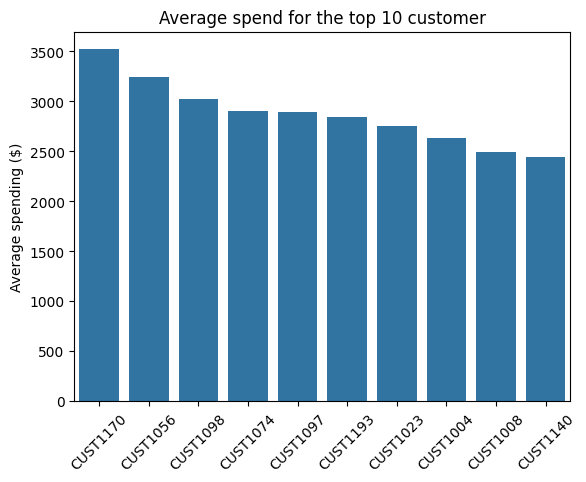

In [14]:
customers_sales.info()

customers_sales['turnover'] = customers_sales['quantity'] * customers_sales['price_each']

avg_spend_customer = customers_sales.groupby('customer_id', as_index=False)['turnover'].mean()

print(avg_spend_customer.head(20))

avg_spend_customer = avg_spend_customer.sort_values(by='turnover', ascending=False).head(10)
sns.barplot(data=avg_spend_customer, x='customer_id', y='turnover')
plt.title('Average spend for the top 10 customer')
plt.xlabel('')
plt.ylabel('Average spending ($)')
plt.xticks(rotation=45)
plt.show()


# Assess revenue lost to returns and excessive discounts

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   transaction_id    0 non-null      object        
 1   discount_applied  0 non-null      float64       
 2   return_flag       0 non-null      object        
 3   customer_id       0 non-null      object        
 4   product_id        0 non-null      object        
 5   quantity          0 non-null      int64         
 6   price_each        0 non-null      float64       
 7   date              0 non-null      datetime64[ns]
 8   category          0 non-null      object        
 9   price             0 non-null      float64       
 10  product_name      0 non-null      object        
 11  return_rate       0 non-null      float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(6)
memory usage: 132.0+ bytes
Empty DataFrame
Columns: [transaction_id, discount_applied, retur

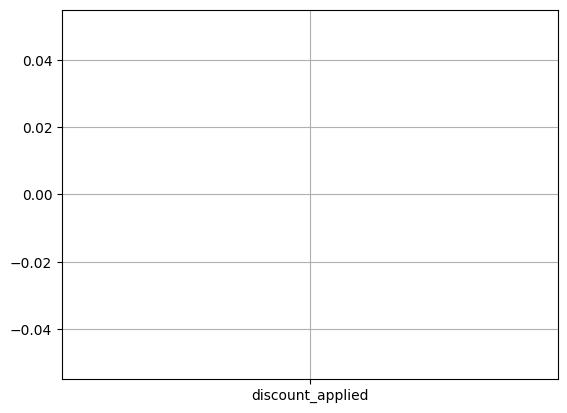

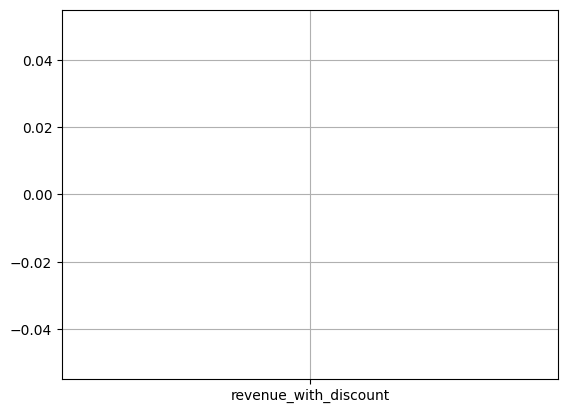

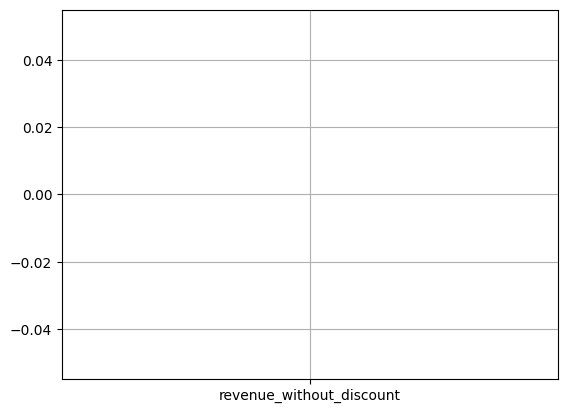

In [15]:
returns_discounts_products.info()

print(returns_discounts_products)

returns_discounts_products.boxplot('discount_applied')
plt.show()

q3 = returns_discounts_products['discount_applied'].quantile(0.75)
q1 = returns_discounts_products['discount_applied'].quantile(0.25)
iqr = q3 - q1
excessive_discounts = returns_discounts_products[returns_discounts_products['discount_applied'] > q3]

 # revenue and excessive discount
excessive_discounts['revenue_with_discount'] = excessive_discounts['discount_applied'] \
* excessive_discounts['price_each'] * excessive_discounts['quantity']

excessive_discounts['revenue_without_discount'] = excessive_discounts['price_each'] * excessive_discounts['quantity']

excessive_discounts.boxplot('revenue_with_discount')
plt.show()

excessive_discounts.boxplot('revenue_without_discount')
plt.show()


## New vs. Returning Customers

H₀: New and returning customers make the same average number of purchases per month.

H₁: Returning customers make more purchases than new ones.

In [16]:
# average number of purchases per month grouped by new and returning
customers_sales.head()

alpha = 0.05

# we group by flag
customers_sales_grouped = customers_sales.groupby(['flag', 'transaction_month'], as_index=False)['transaction_id'].count()

mean_returning = customers_sales_grouped.loc[customers_sales_grouped['flag']=='returning', 'transaction_id'].mean()
mean_new = customers_sales_grouped.loc[customers_sales_grouped['flag']=='new', 'transaction_id'].mean()

print(f'Returning customers make an average number of {mean_returning:.0f} purchases per month')
print(f'New customers make an average number of {mean_new:.0f} purchases per month')

# We perform a ttest to compare two average values
stats, pval = ttest_ind(customers_sales_grouped[customers_sales_grouped['flag'] == 'new']['transaction_id'],
            customers_sales_grouped[customers_sales_grouped['flag'] == 'returning']['transaction_id'], alternative='less')

# try the hypothesis that there are more purchases than the H0
if pval < alpha:
  print('Returning customers make more purchases than new ones')
else:
  print('No strong evidences than returning customers make more purchases than new ones')


Returning customers make an average number of 76 purchases per month
New customers make an average number of 7 purchases per month
Returning customers make more purchases than new ones


## Spending Comparison

H₀: There is no difference in the average order value between male and female customers.

H₁: One gender has a higher average order value than the other.

# Regional Sales Difference

H₀: All regions generate the same average turnover.

H₁: At least one region has a significantly different turnover.

In [17]:
# calculate the avg turnover per region
turnover_region = customers_sales.groupby('region', as_index=False)['turnover'].sum()

east_turnover = turnover_region[turnover_region['region'] == 'East']['turnover']
west_turnover = turnover_region[turnover_region['region'] == 'West']['turnover']
south_turnover = turnover_region[turnover_region['region'] == 'South']['turnover']
north_turnover = turnover_region[turnover_region['region'] == 'North']['turnover']

# We perform a annova hypothesis test to try many group comparison
stats, pval = f_oneway(east_turnover, west_turnover, south_turnover, north_turnover, equal_var=False)

if pval < alpha:
  print('Null hypothesis rejected. At least one region has a significantly different turnover')
else:
  print('Fail to reject the null hypothesis.\
  We cannot say with evidence that at least one region has a significantly different turnover')

Fail to reject the null hypothesis.  We cannot say with evidence that at least one region has a significantly different turnover


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: SmallSampleWarning: all input arrays have length 1.  f_oneway requires that at least one input has length greater than 1.
  if is_too_small(samples, kwds):
/tmp/ipython-input-1467880776.py:10: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stats, pval = f_oneway(east_turnover, west_turnover, south_turnover, north_turnover, equal_var=False)


# Product Popularity

H₀: All product categories are purchased at the same rate.

H₁: Some product categories are more popular than others.

In [18]:
# Calculate the number of purchases per category